In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision.datasets import MNIST

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

def plot_data_dist(settings_files):
    train_data = MNIST(root='data', train=True)
    fig, ax = plt.subplots(1, len(settings_files), figsize=(23, 5))
    alpha = [10, 1, 0.1 , 0.01]
    for j, set in enumerate(settings_files):

        settings_path = f"./settings/{set}"
        local_indices = []
        with open(f"{settings_path}/data_splits.npy", "rb") as f:
            public_indices = np.load(f)
            try:
                while True:
                    local_indices.append(np.load(f))
            except:
                pass
        
        client_targets = [train_data.targets[indices].tolist() for indices in local_indices]
        n_clients = len(client_targets)
        n_classes = 10

        label_count_matrix = np.array([[np.sum(np.array(client_targets[i]) == c) for c in range(n_classes)] for i in range(n_clients)])
        n_samples = sum(sum(label_count_matrix))
        y_values = range(n_classes)
        for i in range(n_clients):
            s = [5000*label_count_matrix[i][c]/n_samples for c in range(n_classes)]
            x_values = [i]*n_classes
            ax[j].scatter(x_values, y_values, s=s, c='blue')
        ax[j].set_xlabel('Client nr')
        ax[j].set_ylabel('Data label')
        ax[j].set_xticks(np.arange(n_clients))
        ax[j].set_yticks(np.arange(n_classes))
        ax[j].set_title(r'$\alpha={}$'.format(alpha[j]))
        ax[j].set_axisbelow(True)
        ax[j].grid()
    plt.savefig('data_example.png', dpi=300)
    plt.show()

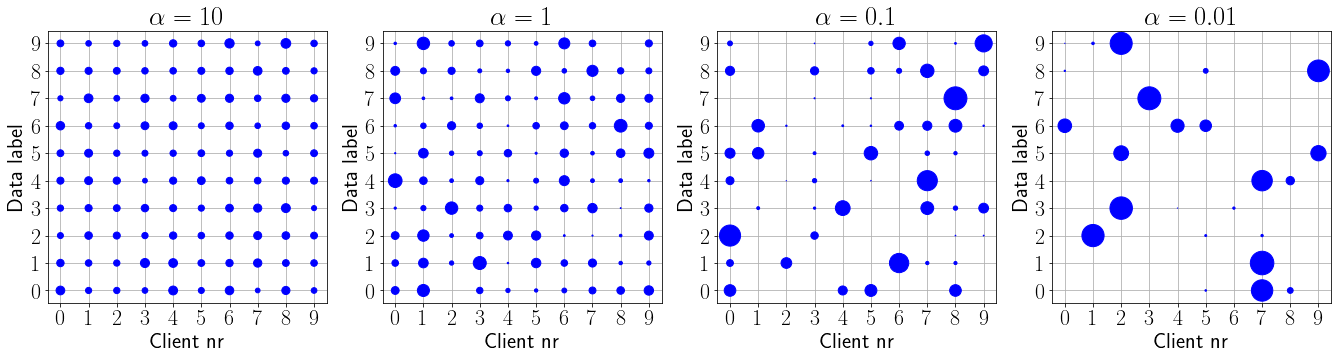

In [14]:
dists = ["niid10.0", "niid1.0", "niid0.1", "niid0.01"] 
n_clients = 10
model = "mnist_cnn1"
settings_files = [f"{model}_c{n_clients}_{d}_s1" for d in dists]
plot_data_dist(settings_files)

In [21]:
from torch.nn import Conv2d, Sequential
import torch
import torch.nn as nn

c = 3
s = 32
b = 2
t = torch.zeros([b, c, s, s])

In [33]:
encoder_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 3, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(32, 64, 3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.Conv2d(64, 128, 3, stride=2, padding=0),
    nn.ReLU(True)
)

### Flatten layer
flatten = nn.Flatten(start_dim=1)
### Linear section
encoder_lin = nn.Sequential(
    nn.Linear(3 * 3 * 128, 128),
    nn.ReLU(True),
    nn.Linear(128, 4)
)

decoder_lin = nn.Sequential(
    nn.Linear(4, 128),
    nn.ReLU(True),
    nn.Linear(128, 3 * 3 * 128),
    nn.ReLU(True)
)

unflatten = nn.Unflatten(dim=1, 
unflattened_size=(128, 3, 3))

decoder_conv = nn.Sequential(
    nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=0),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 32, 3, stride=2, 
    padding=0, output_padding=0),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    nn.ConvTranspose2d(32, 3, 3, stride=2, 
    padding=0, output_padding=1)
)

x = encoder_cnn(t)
x = encoder_lin(flatten(x))
x = unflatten(decoder_lin(x))
x = decoder_conv(x)
x.shape

torch.Size([2, 3, 32, 32])